# Brain Tumor Detection using MRI Scans

# This project develops an automated brain tumor detection system using MRI scan images, leveraging transfer learning with ResNet50V2 for binary classification (Tumor/No Tumor).

In [6]:
import os
for class_name in os.listdir('/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train'):
    labels_folder = os.path.join('/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train', class_name, 'labels')
    if os.path.exists(labels_folder):
        for label_file in os.listdir(labels_folder):
            with open(os.path.join(labels_folder, label_file), 'r') as f:
                content = f.read().strip()
                print(f"{label_file}: {content}")

p (508).txt: 3 0.511719 0.499023 0.074219 0.044922
Te-pi_0068.txt: 3 0.520508 0.529297 0.130859 0.078125
3 0.512695 0.613281 0.119141 0.085938
p (593).txt: 3 0.427734 0.584961 0.144531 0.130859
p (743).txt: 3 0.486328 0.536133 0.093750 0.107422
p (712).txt: 3 0.493164 0.395508 0.115234 0.095703
Tr-pi_1232.txt: 3 0.504883 0.510742 0.126953 0.134766
p (669).txt: 3 0.504883 0.395508 0.103516 0.080078
Tr-pi_0604.txt: 3 0.514648 0.391602 0.107422 0.083984
p (595).txt: 3 0.395508 0.634766 0.119141 0.125000
p (372).txt: 3 0.495117 0.510742 0.119141 0.130859
Tr-pi_0494.txt: 3 0.509766 0.407227 0.132812 0.099609
Tr-pi_0035.txt: 3 0.471116 0.508964 0.089641 0.101594
Tr-pi_0132.txt: 3 0.425781 0.634766 0.109375 0.140625
p (200).txt: 3 0.477539 0.503906 0.072266 0.042969
Tr-pi_0584.txt: 3 0.501953 0.397461 0.074219 0.087891
p (588).txt: 3 0.414062 0.508789 0.070312 0.048828
Tr-pi_0646.txt: 3 0.490234 0.401367 0.101562 0.091797
Tr-pi_1355.txt: 3 0.597656 0.562500 0.222656 0.281250
p (746).txt: 3 0.

# Setup and Imports

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import cv2

# Constants & Globals

In [30]:
BASE_DIR = '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
TUMOR_CLASSES = ['Glioma', 'Meningioma', 'Pituitary']

# Dataset Loader

In [31]:
def get_image_paths_and_labels(base_dir=BASE_DIR):
    image_paths, labels, bboxes = [], [], []
    
    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"Dataset directory {base_dir} does not exist")
    
    train_dir = os.path.join(base_dir, 'Train')
    train_count = 0
    if os.path.exists(train_dir):
        print(f"Scanning Train directory: {train_dir}")
        for class_name in os.listdir(train_dir):
            class_path = os.path.join(train_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            
            label = 1 if class_name in TUMOR_CLASSES else 0
            image_folder = os.path.join(class_path, 'images')
            if os.path.exists(image_folder):
                img_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
                print(f"Found {len(img_files)} images in {image_folder}")
                for img_name in img_files:
                    img_path = os.path.join(image_folder, img_name)
                    labels_folder = os.path.join(class_path, 'labels')
                    if os.path.exists(labels_folder):
                        bbox_path = os.path.join(labels_folder, img_name.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
                        if os.path.exists(bbox_path):
                            try:
                                with open(bbox_path, 'r') as f:
                                    bbox_values = [float(x) for x in f.read().strip().split()]
                                    bbox = bbox_values[:4] if len(bbox_values) >= 4 else [0.0, 0.0, 0.0, 0.0]
                            except (ValueError, IndexError):
                                bbox = [0.0, 0.0, 0.0, 0.0]
                        else:
                            bbox = [0.0, 0.0, 0.0, 0.0]
                    else:
                        bbox = [0.0, 0.0, 0.0, 0.0]
                    image_paths.append(img_path)
                    labels.append(label)
                    bboxes.append(bbox)
                    train_count += 1
    
    val_dir = os.path.join(base_dir, 'Val')
    val_count = 0
    if os.path.exists(val_dir):
        print(f"Scanning Val directory: {val_dir}")
        for class_name in os.listdir(val_dir):
            class_path = os.path.join(val_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            
            label = 1 if class_name in TUMOR_CLASSES else 0
            image_folder = os.path.join(class_path, 'images')
            if os.path.exists(image_folder):
                img_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
                print(f"Found {len(img_files)} images in {image_folder}")
                for img_name in img_files:
                    img_path = os.path.join(image_folder, img_name)
                    image_paths.append(img_path)
                    labels.append(label)
                    bboxes.append([0.0, 0.0, 0.0, 0.0])
                    val_count += 1
            else:
                print(f"No 'images' subfolder found in {class_path}, checking direct files")
                img_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
                print(f"Found {len(img_files)} images directly in {class_path}")
                for img_name in img_files:
                    img_path = os.path.join(class_path, img_name)
                    image_paths.append(img_path)
                    labels.append(label)
                    bboxes.append([0.0, 0.0, 0.0, 0.0])
                    val_count += 1
    
    if not image_paths:
        raise ValueError(f"No valid images found in {base_dir}. Check directory structure and file formats.")
    
    if not (len(image_paths) == len(labels) == len(bboxes)):
        raise ValueError(f"Mismatch in sequence lengths: images={len(image_paths)}, labels={len(labels)}, bboxes={len(bboxes)}")
    
    print(f"Total images found: {len(image_paths)} (Train: {train_count}, Val: {val_count})")
    return image_paths, labels, bboxes

# Image Processing Functions

In [ ]:
def preprocess_image(path, label, bbox):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    if img.shape is None or len(img.shape) < 2:
        raise ValueError(f"Invalid image shape for {path}: {img.shape}")
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.ensure_shape(img, [224, 224, 3])
    return img, tf.cast(label, tf.int32), bbox

def augment_image(img, label, bbox):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    return img, label, bbox

def create_dataset(image_paths, labels, bboxes, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels, bboxes))
    ds = ds.shuffle(len(image_paths)) if augment else ds
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    ds = ds.map(lambda x, y, z: (x, y))
    return ds, len(image_paths)

def load_datasets(base_dir=BASE_DIR):
    image_paths, labels, bboxes = get_image_paths_and_labels(base_dir)
    
    train_mask = [os.path.dirname(p).startswith(os.path.join(base_dir, 'Train')) for p in image_paths]
    train_paths = [p for p, m in zip(image_paths, train_mask) if m]
    val_paths = [p for p, m in zip(image_paths, train_mask) if not m]
    train_labels = [l for l, m in zip(labels, train_mask) if m]
    val_labels = [l for l, m in zip(labels, train_mask) if not m]
    train_bboxes = [b for b, m in zip(bboxes, train_mask) if m]
    val_bboxes = [b for b, m in zip(bboxes, train_mask) if not m]
    
    if not train_paths:
        raise ValueError("No training images found.")
    train_ds, train_size = create_dataset(train_paths, train_labels, train_bboxes, augment=True)
    
    if not val_paths:
        print("Warning: No validation images found. Proceeding with only training data.")
        val_ds, val_size = None, 0
    else:
        val_ds, val_size = create_dataset(val_paths, val_labels, val_bboxes, augment=False)
    
    return train_ds, train_size, val_ds, val_size, image_paths, bboxes, train_mask

# Load Datasets

In [32]:
try:
    train_ds, train_size, val_ds, val_size, image_paths, bboxes, train_mask = load_datasets()
    print(f"Train size: {train_size}, Val size: {val_size}")
    for x, y in train_ds.take(1):
        print(f"Sample train batch shape: {x.shape}, Sample train label shape: {y.shape}")
    if val_ds is not None:
        for x, y in val_ds.take(1):
            print(f"Sample val batch shape: {x.shape}, Sample val label shape: {y.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Scanning Train directory: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train
Found 1424 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images
Found 711 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/No Tumor/images
Found 1449 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Meningioma/images
Found 1153 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Glioma/images
Scanning Val directory: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val
Found 136 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/images
Found 100 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/images
Found 140 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Meningioma/images
Found 136 images in /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/images
Total images found: 5249 (Train: 4737, Val: 512)
Train size: 4737, 

# Model Definition

In [33]:
def build_model(freeze=True):
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))

    if freeze:
        base_model.trainable = False
    else:
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        for layer in base_model.layers[-20:]:
            layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

model = build_model()
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_26     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

# Model Training

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

if val_ds is not None:
    history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping])
else:
    history = model.fit(train_ds, epochs=10, callbacks=[early_stopping])
    print("Warning: Training without validation data.")

model = build_model(freeze=False)
if val_ds is not None:
    history = model.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[early_stopping])
else:
    history = model.fit(train_ds, epochs=5, callbacks=[early_stopping])
    print("Warning: Fine-tuning without validation data.")

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.8551 - auc_26: 0.8194 - loss: 0.3403 - val_accuracy: 0.9336 - val_auc_26: 0.9680 - val_loss: 0.1790
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9576 - auc_26: 0.9744 - loss: 0.1218 - val_accuracy: 0.9473 - val_auc_26: 0.9820 - val_loss: 0.1352
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9619 - auc_26: 0.9793 - loss: 0.1069 - val_accuracy: 0.9570 - val_auc_26: 0.9871 - val_loss: 0.1036
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9701 - auc_26: 0.9878 - loss: 0.0892 - val_accuracy: 0.9629 - val_auc_26: 0.9916 - val_loss: 0.0896
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9706 - auc_26: 0.9884 - loss: 0.0860 - val_accuracy: 0.9590 - val_auc_26: 0.9884 - val_loss: 0.0956
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9714 - auc_26: 0.9899 - loss: 0.0808 - val_accuracy: 0.9668 - val_auc_26: 0.9926 - val_loss:

# Evaluation & Plots

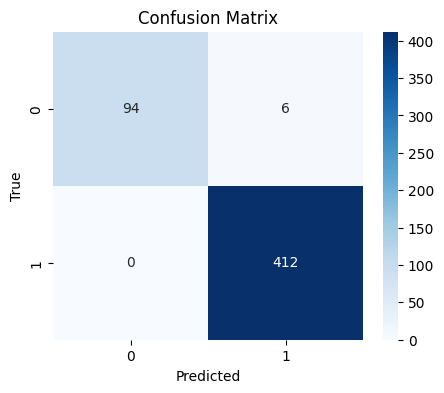

Sensitivity (Recall): 1.0000
Specificity: 0.9400

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.94      0.97       100
       Tumor       0.99      1.00      0.99       412

    accuracy                           0.99       512
   macro avg       0.99      0.97      0.98       512
weighted avg       0.99      0.99      0.99       512



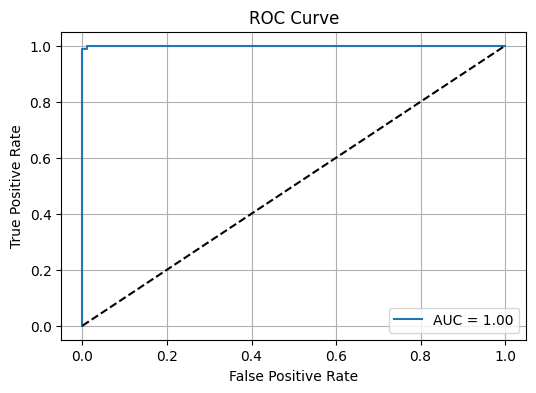

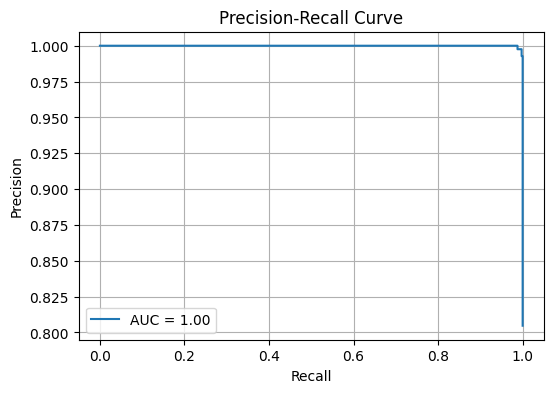

In [35]:
y_true, y_pred = [], []
val_image_paths = [p for p, m in zip(image_paths, [not m for m in train_mask]) if not m]
val_bboxes = [b for b, m in zip(bboxes, [not m for m in train_mask]) if not m] 

if val_ds is not None:
    for x_batch, y_batch in val_ds:
        preds = model.predict(x_batch, verbose=0).flatten()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)
else:
    print("Warning: No validation data for evaluation. Using a subset of training data instead.")
    for x_batch, y_batch in train_ds.take(1):
        preds = model.predict(x_batch, verbose=0).flatten()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

y_pred_label = [1 if p > 0.5 else 0 for p in y_pred]

# confusion matrix

if y_true:
    cm = confusion_matrix(y_true, y_pred_label)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
else:
    print("No data for confusion matrix.")

# sensitivity and specificity calculation

if y_true:
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
else:
    print("No data for sensitivity and specificity calculation.")

# classification report

if y_true:
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_label, target_names=['No Tumor', 'Tumor']))
else:
    print("No data for classification report.")

# ROC curve

if y_true:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data for ROC curve.")

# Precision-Recall curve

if y_true:
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data for Precision-Recall curve.")

# Tumor Detection Visualization with Bounding Box and Grad-CAM

Processing image 1/5: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/Tr-pi_0282.jpg


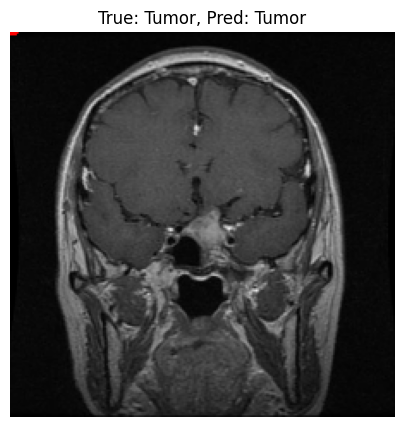

img_array shape: (1, 224, 224, 3)
Model name: sequential_27
Model built: True
Base model name: resnet50v2
Found conv layer: conv5_block3_out
Error processing Grad-CAM for image /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/Tr-pi_0282.jpg: The layer sequential_27 has never been called and thus has no defined output.
Processing image 2/5: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/Te-pi_0059.jpg


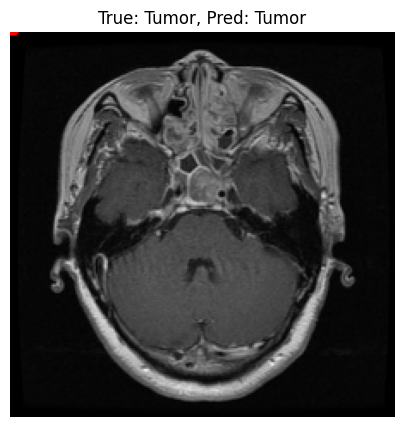

img_array shape: (1, 224, 224, 3)
Model name: sequential_27
Model built: True
Base model name: resnet50v2
Found conv layer: conv5_block3_out
Error processing Grad-CAM for image /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/Te-pi_0059.jpg: The layer sequential_27 has never been called and thus has no defined output.
Processing image 3/5: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (538).jpg


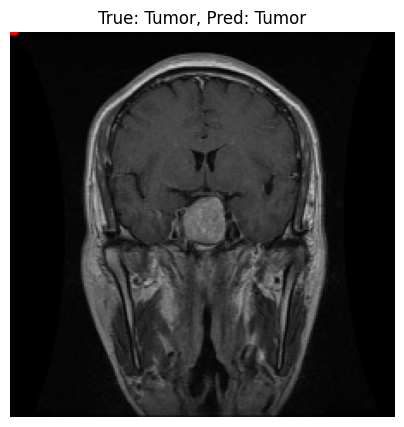

img_array shape: (1, 224, 224, 3)
Model name: sequential_27
Model built: True
Base model name: resnet50v2
Found conv layer: conv5_block3_out
Error processing Grad-CAM for image /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (538).jpg: The layer sequential_27 has never been called and thus has no defined output.
Processing image 4/5: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (374).jpg


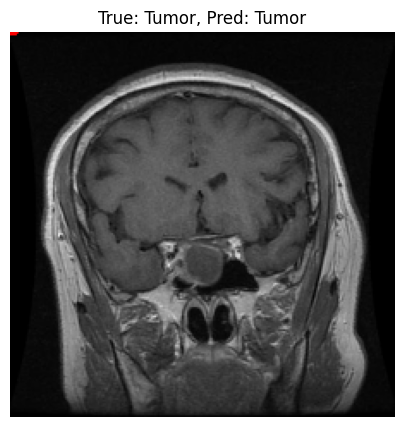

img_array shape: (1, 224, 224, 3)
Model name: sequential_27
Model built: True
Base model name: resnet50v2
Found conv layer: conv5_block3_out
Error processing Grad-CAM for image /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (374).jpg: The layer sequential_27 has never been called and thus has no defined output.
Processing image 5/5: /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (455).jpg


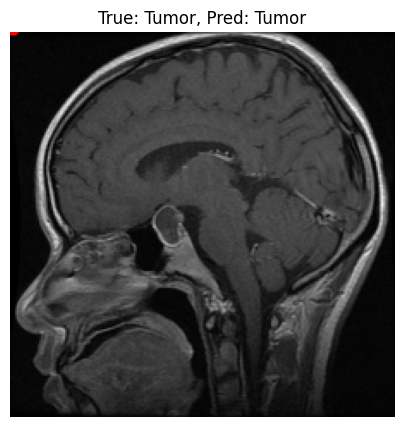

img_array shape: (1, 224, 224, 3)
Model name: sequential_27
Model built: True
Base model name: resnet50v2
Found conv layer: conv5_block3_out
Error processing Grad-CAM for image /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (455).jpg: The layer sequential_27 has never been called and thus has no defined output.


In [39]:
def plot_bounding_box(image_path, bbox, label, pred_label):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if sum(bbox) > 0:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"True: {'Tumor' if label else 'No Tumor'}, Pred: {'Tumor' if pred_label else 'No Tumor'}")
    plt.axis('off')
    plt.show()

def get_gradcam_heatmap(model, img_array, last_conv_layer_name='conv5_block3_out'):
    print(f"Model name: {model.name}")
    print(f"Model built: {model.built}")
    base_model = model.layers[0]
    if not model.built:
        print(f"Building model with input shape: {img_array.shape}")
        model.predict(img_array, verbose=0)
    print(f"Base model name: {base_model.name}")
    try:
        conv_layer = base_model.get_layer(last_conv_layer_name)
        print(f"Found conv layer: {last_conv_layer_name}")
    except ValueError as e:
        print(f"Error: Layer {last_conv_layer_name} not found in base model. Available layers:")
        for layer in base_model.layers:
            print(layer.name)
        raise e
    grad_model = Model(inputs=base_model.input, outputs=[conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        raise ValueError("Gradient computation failed. Check model structure and input compatibility.")
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)
    return heatmap

def plot_gradcam(image_path, heatmap, label, pred_label):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image for Grad-CAM: {image_path}")
        return
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    heatmap = cv2.resize(heatmap.numpy(), IMAGE_SIZE)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM: True: {'Tumor' if label else 'No Tumor'}, Pred: {'Tumor' if pred_label else 'No Tumor'}")
    plt.axis('off')
    plt.show()

# Example usage with debugging
if val_image_paths:
    for i in range(min(5, len(val_image_paths))):
        print(f"Processing image {i+1}/{min(5, len(val_image_paths))}: {val_image_paths[i]}")
        label = y_true[i]
        pred_label = y_pred_label[i]
        bbox = val_bboxes[i]
        plot_bounding_box(val_image_paths[i], bbox, label, pred_label)
        img = cv2.imread(val_image_paths[i])
        if img is None:
            print(f"Invalid image file: {val_image_paths[i]}")
            continue
        img_array = tf.expand_dims(tf.image.decode_image(tf.io.read_file(val_image_paths[i]), channels=3), 0)
        img_array = tf.image.resize(img_array, IMAGE_SIZE) / 255.0
        print(f"img_array shape: {img_array.shape}")
        try:
            heatmap = get_gradcam_heatmap(model, img_array)
            plot_gradcam(val_image_paths[i], heatmap, label, pred_label)
        except Exception as e:
            print(f"Error processing Grad-CAM for image {val_image_paths[i]}: {str(e)}")
else:
    print("No validation images available for visualization.")